In [1]:
import pygplates
import pandas as pd
import sys
#sys.path.append('/Users/Simon/GIT/PlateTectonicTools/')
#import ptt.subduction_convergence as sc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

%matplotlib inline
%load_ext autoreload
%autoreload 2

print pygplates.__version__

from reconstruction_classes import *


2.1.0.19


In [2]:
# Build an object describing a reconstruction model

M2016 = ReconstructionModel('Matthews++2016')
M2016.add_rotation_model('/Applications/GPlates-2.0.0/SampleData/FeatureCollections/Rotations/Matthews_etal_GPC_2016_410-0Ma_GK07.rot')
M2016.add_static_polygons('/Applications/GPlates-2.0.0/SampleData/FeatureCollections/StaticPolygons/Muller_etal_AREPS_2016_StaticPolygons.gpmlz')
M2016.add_dynamic_polygons('/Applications/GPlates-2.0.0/SampleData/FeatureCollections/DynamicPolygons/Matthews_etal_GPC_2016_MesozoicCenozoic_PlateTopologies.gpmlz')
M2016.add_dynamic_polygons('/Applications/GPlates-2.0.0/SampleData/FeatureCollections/DynamicPolygons/Matthews_etal_GPC_2016_Paleozoic_PlateTopologies.gpmlz')
M2016.add_dynamic_polygons('/Applications/GPlates-2.0.0/SampleData/FeatureCollections/DynamicPolygons/Matthews_etal_GPC_2016_TopologyBuildingBlocks.gpmlz')


In [6]:
# Example where the point data are in a local csv file
# need to know the column names that map to 

ore_deposit_data = AgeCodedPointDataset('../Data/ngeo2429-s2.csv',
                                        field_mapping = {'longitude_field':'Long.',
                                                         'latitude_field':'Lat.',
                                                         'max_age_field':'Age (Ma)'})

# assign plate ids based on an existing 'ReconstructionModel' class
ore_deposit_data.assign_reconstruction_model(M2016)

# Plot reconstructed point locations at some time snapshot
#ore_deposit_data.plot_reconstructed(20.)

ore_deposit_data

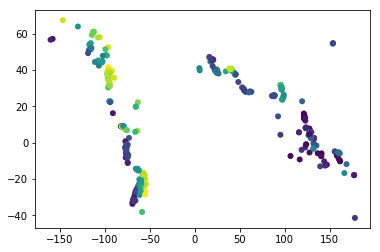

In [7]:
# reconstruct each point to its time of appearance
reconstructed_ore_deposit_data = ore_deposit_data.reconstruct_to_time_of_appearance()


plt.figure()
plt.scatter(zip(*reconstructed_ore_deposit_data)[0],
            zip(*reconstructed_ore_deposit_data)[1],
            c=zip(*reconstructed_ore_deposit_data)[2],edgecolors='')


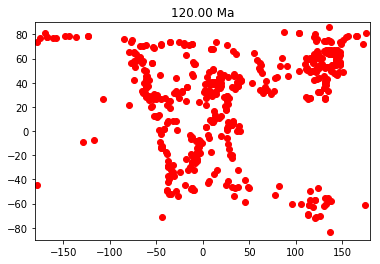

In [8]:
# load data from a local shapefile
paleolithology_data = AgeCodedPointDataset('../Data/boucot_paleolithology_combined.shp')

paleolithology_data.assign_reconstruction_model(M2016)

paleolithology_data.plot_reconstructed(120.)


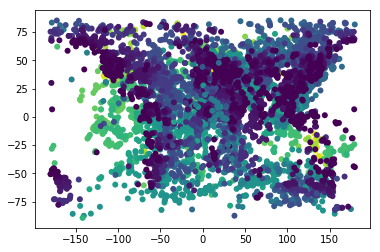

In [9]:
reconstructed_paleolithology_data = paleolithology_data.reconstruct_to_time_of_appearance()

plt.figure()
plt.scatter(zip(*reconstructed_paleolithology_data)[0],
            zip(*reconstructed_paleolithology_data)[1],
            c=zip(*reconstructed_paleolithology_data)[2],edgecolors='')


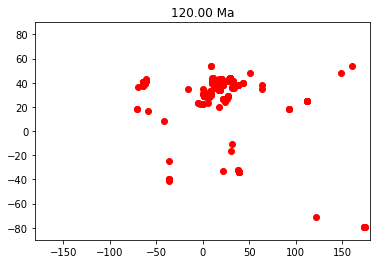

In [10]:
# load data from the paleobiology database web service

#parameter_dict = {'base_name':'Bryozoa',
#                  'max_ma':200.,
#                  'min_ma':0.}

url = 'https://paleobiodb.org/data1.2/occs/list.csv?base_name=Bryozoa&max_ma=200&min_ma=0&show=coords'

paleobiology_data = AgeCodedPointDataset(url)

paleobiology_data.assign_reconstruction_model(M2016)

paleobiology_data.plot_reconstructed(120.)


(array([ 0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  2.,  0.,
        1.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  4.,  4.,  5.,  5., 10.,
        6.,  2.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]), array([-90, -85, -80, -75, -70, -65, -60, -55, -50, -45, -40, -35, -30,
       -25, -20, -15, -10,  -5,   0,   5,  10,  15,  20,  25,  30,  35,
        40,  45,  50,  55,  60,  65,  70,  75,  80,  85,  90]))


/Users/Simon/GIT/GPlatesReconstructionModel/reconstruction_classes.py:589: RuntimeWarning: invalid value encountered in divide
  return np.nansum(result[0]/result[0],axis=0),bin_edges[1]


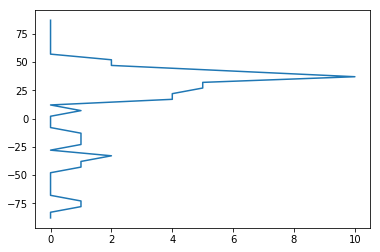

In [11]:
binsize = 5
result = paleobiology_data.spatial_binning(reconstruction_time=120.,binsize=binsize,axis='latitude')

print result

plt.plot(result[0],result[1][:-1]+binsize/2)


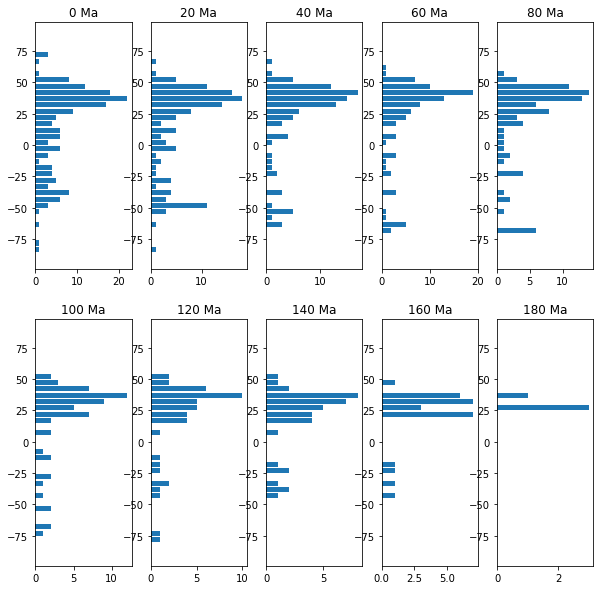

In [12]:
# loop over a series of times, get the latitudinal distribution for the same dataset
# but with the validly reconstructed features for each time

plt.figure(figsize=(10,10))
for index,time in enumerate(range(0,200,20)):
    result = paleobiology_data.spatial_binning(reconstruction_time=time,binsize=binsize,axis='latitude')
    plt.subplot(2,5,index+1)
    plt.barh(result[1][:-1]+binsize/2,result[0],4)
    plt.title('%0.0f Ma' % time)
    

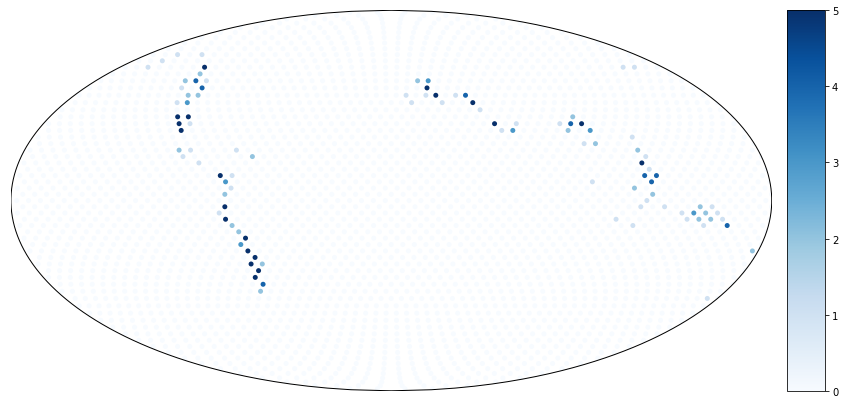

In [13]:
# create an equal area point distribution object
equal_area_points = PointDistributionOnSphere(distribution_type='healpix',N=16)

# plot a heatmap of the point density
bin_counts = equal_area_points.point_feature_heatmap(
    [point.get_geometry() for point in ore_deposit_data._point_features])

plt.figure(figsize=(16,7))
m = Basemap(projection='moll',lon_0=0)
x,y = m(equal_area_points.longitude,
        equal_area_points.latitude)
m.scatter(x,y,c=bin_counts, s=25, edgecolors='', vmax=5, cmap=plt.cm.Blues)
m.colorbar()
plt.show()

